In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

path = 'data'

X0, V, pos = torch.load(f"{path}/X0.pt"), torch.load(f"{path}/V.pt"), torch.load(f"{path}/pos.pt")
X0.shape, V.shape, pos.shape


C:\Users\Sathya\AppData\Local\Temp\ipykernel_27440\2194220962.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X0, V, pos = torch.load(f"{path}/X0.pt"), torch.load(f"{pat

(torch.Size([10000, 2]),
 torch.Size([10000, 100, 2]),
 torch.Size([10000, 100, 2]))

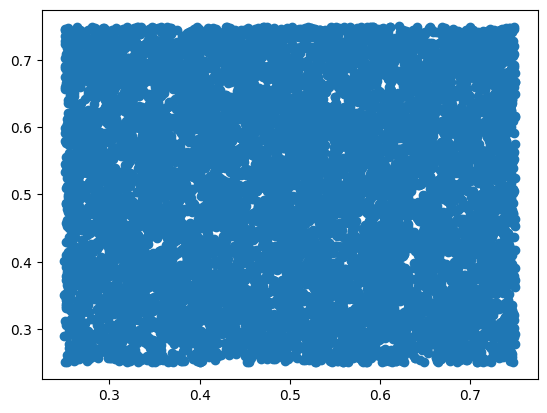

In [25]:
plt.scatter(X0[:, 0], X0[:, 1])

In [2]:
import torch
torch.set_default_dtype(torch.float64)
from geodesic_solver import Immersed_Manifold

def model_tanh(hidden_dims: list):
    model = torch.nn.Sequential(
        torch.nn.Linear(2, hidden_dims[0]),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden_dims[0], hidden_dims[1]),
        torch.nn.Tanh(),
        torch.nn.Linear(hidden_dims[1], 1)
    )
    return model

f = model_tanh([32, 32])
# f.load_state_dict(torch.load('Recon_Surface\\neural_surface.pth'))
f.load_state_dict(torch.load('neural_surface.pth'))

class Surface:
    # def __init__(self, a, c):
    #     self.a = a
    #     self.c = c
    def immersion(self, point):
        """Immersion. Input is a batch of 2-tupes in the unit square."""
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        X = point[..., 0]
        Y = point[..., 1]
        Z = f(point).squeeze(-1)  

        return torch.stack(
            [X, Y, Z],
            axis=-1,
        ).to(device)

    def jacobian_matrix_batch(self, pts):

            # Ensure we're on the right device
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            pts = pts.to(device)
            batch_size = pts.shape[0]
            
            # Create the Jacobian tensor
            jacobian = torch.zeros(batch_size, 3, 2, device=device)
            
            # Set the known derivatives for X and Y components
            # For the X component (immersed_pts[:, 0]):
            jacobian[:, 0, 0] = 1.0  # ∂X/∂x = 1
            jacobian[:, 0, 1] = 0.0  # ∂X/∂y = 0
            
            # For the Y component (immersed_pts[:, 1]):
            jacobian[:, 1, 0] = 0.0  # ∂Y/∂x = 0
            jacobian[:, 1, 1] = 1.0  # ∂Y/∂y = 1
            
            # Only compute gradients for the Z component
            # Clone and set requires_grad to avoid modifying the input tensor
            pts_grad = pts.detach().clone().requires_grad_(True)
            
            # Compute only the Z component
            z_values = f(pts_grad).squeeze()
            
            # Compute gradients of Z with respect to inputs
            z_grad = torch.autograd.grad(
                outputs=z_values,
                inputs=pts_grad,
                grad_outputs=torch.ones_like(z_values, device=device),
                create_graph=True,
                only_inputs=True
            )[0]
            
            # Store Z gradients in the Jacobian tensor
            jacobian[:, 2, :] = z_grad
            
            return jacobian

    def exp(self, base_pts, velocities):
        "Computes exponential maps"
        immersed_manifold = Immersed_Manifold(f=f)
        return immersed_manifold.exp(base_pts, velocities)


 
surface = Surface()


# diff, V_3d

C:\Users\Sathya\AppData\Local\Temp\ipykernel_27440\1644232.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  f.load_state_dict(torch.load('neural_surface.pth'))


In [3]:
k = 1
pos_3d = surface.immersion(pos)
jacobian_matrices = surface.jacobian_matrix_batch(pos[:,k])
# jacobian_matrices.shape, V[:,0].unsqueeze(dim=-1).shape
V_3d = torch.bmm(jacobian_matrices, V[:,k+1].unsqueeze(dim=-1)).squeeze()
diff = pos_3d[:,k+1]-pos_3d[:,k]
# V_3d.shape, diff.shape


In [6]:
i=2
(diff[:,i] - V_3d[:,i]).abs().median()

tensor(3.1703e-05, grad_fn=<MedianBackward0>)

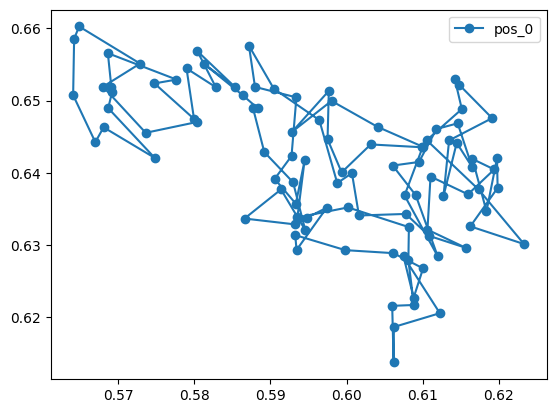

In [7]:
n=2
plt.plot(pos[n, :, 0].detach(), pos[n, :, 1].detach(), '-o', label='pos_0')
plt.legend()


In [9]:
# plt.hist(pos[:,:,0].detach())
pos.max(), pos.min(), pos.mean(), pos.std()

(tensor(0.8906, grad_fn=<MaxBackward1>),
 tensor(0.1269, grad_fn=<MinBackward1>),
 tensor(0.5019, grad_fn=<MeanBackward0>),
 tensor(0.1477, grad_fn=<StdBackward0>))

In [23]:
(surface.immersion(pos)).diff(dim=1).norm(dim=-1).median()
# pos.diff(dim=1).norm(dim=-1).mean()

tensor(0.0704, grad_fn=<MedianBackward0>)

In [20]:
from torus_math import Torus
torus = Torus(a=1, c=4)
pos_3d = torus.immersion(pos[:,0])
jacobian_matrices = torus.jacobian_matrix_batch(X0)
jacobian_matrices.shape, V[:,0].unsqueeze(dim=-1).shape
V_3d = torch.bmm(jacobian_matrices, V[:,0].unsqueeze(dim=-1)).squeeze()
diff = pos_3d-torus.immersion(X0)
diff, V_3d

(tensor([[-0.0364,  0.0161,  0.0114],
         [-0.0262, -0.0295,  0.0349],
         [ 0.0242,  0.0933, -0.0192],
         ...,
         [ 0.0375, -0.0345,  0.0023],
         [ 0.0341,  0.0141,  0.0056],
         [ 0.0575, -0.0836, -0.0143]], grad_fn=<SubBackward0>),
 tensor([[-0.0367,  0.0156, -0.0106],
         [-0.0274, -0.0307, -0.0345],
         [ 0.0285,  0.0886,  0.0231],
         ...,
         [ 0.0377, -0.0342, -0.0036],
         [ 0.0346,  0.0143, -0.0057],
         [ 0.0546, -0.0775,  0.0149]], grad_fn=<SqueezeBackward0>))

In [36]:
i=3
print(f'Euclidean displacement {pos[0].diff(dim=0)[i]}')
print(f'Velocities {V[0,i+1]}')

Euclidean displacement tensor([0.0049, 0.0557], grad_fn=<SelectBackward0>)
Velocities tensor([0.0054, 0.0557], grad_fn=<SelectBackward0>)


In [5]:
import pickle
def unpickle_list(filename):
    """
    Unpickles a list from a file.

    Args:
        filename (str): The filename to load the pickled list from.

    Returns:
        list or None: The unpickled list, or None if an error occurred.
    """
    try:
        with open(filename, 'rb') as f:  # 'rb' for read binary
            loaded_list = pickle.load(f)
        print(f"List unpickled from {filename}")
        return loaded_list
    except FileNotFoundError:
        print(f"Error: File not found at {filename}")
        return None
    except (IOError, pickle.UnpicklingError) as e: #Handles more possible errors
        print(f"Error unpickling list: {e}")
        return None
    

unpickle_list('runtimes_dim_8.pkl')

List unpickled from runtimes_dim_8.pkl


[0.14872288703918457,
 0.09399938583374023,
 0.09020471572875977,
 0.08251452445983887,
 0.13127493858337402,
 0.09063410758972168,
 0.0845937728881836,
 0.10508394241333008,
 0.08269214630126953,
 0.09990859031677246]